# Contextualized Bayesian Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from contextualized.dags.graph_utils import simulate_linear_sem

n = 1000
C = np.linspace(1, 2, n).reshape((n, 1))
W = np.zeros((4, 4, n, 1))
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

In [3]:
from contextualized.easy import ContextualizedBayesianNetworks

cbn = ContextualizedBayesianNetworks(encoder_type='mlp', num_archetypes=16,
                                     n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
                                    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
                                    learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/docs/demos/lightning_logs/boot_0_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type      | Params
---------------------------------------------
0 | encoder        | MLP       | 1.8 K 
1 | explainer      | Explainer | 256   
2 | factor_softmax | Softmax   | 0     
---------------------------------------------
2.0 K     Trainable para

Received unknown keyword argument remove_model_kwargs, probably ignoring.
Received unknown keyword argument archetype_dag_loss_type, probably ignoring.
Received unknown keyword argument archetype_alpha, probably ignoring.
Received unknown keyword argument sample_specific_dag_loss_type, probably ignoring.
Received unknown keyword argument sample_specific_alpha, probably ignoring.


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/docs/demos/lightning_logs/boot_1_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type      | Params
---------------------------------------------
0 | encoder        | MLP       | 1.8 K 
1 | explainer      | Explainer | 256   
2 | factor_softmax | Softmax   | 0     
---------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [4]:
# We can measure Mean-Squared Error to measure likelihood of X under predicted networks.
mses = cbn.measure_mses(C, X)

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 800it [00:00, ?it/s]

Predicting: 800it [00:00, ?it/s]

Predicting: 800it [00:00, ?it/s]

Predicting: 800it [00:00, ?it/s]

Text(0.5, 1.0, 'Ground-Truth Network')

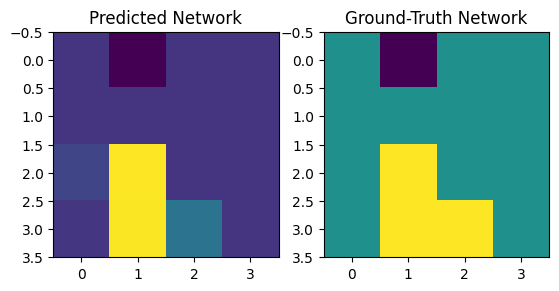

In [5]:
# Predict and visualize network
predicted_networks = cbn.predict_networks(C)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(predicted_networks[0])
axarr[1].imshow(W[0])
axarr[0].set_title("Predicted Network")
axarr[1].set_title("Ground-Truth Network")

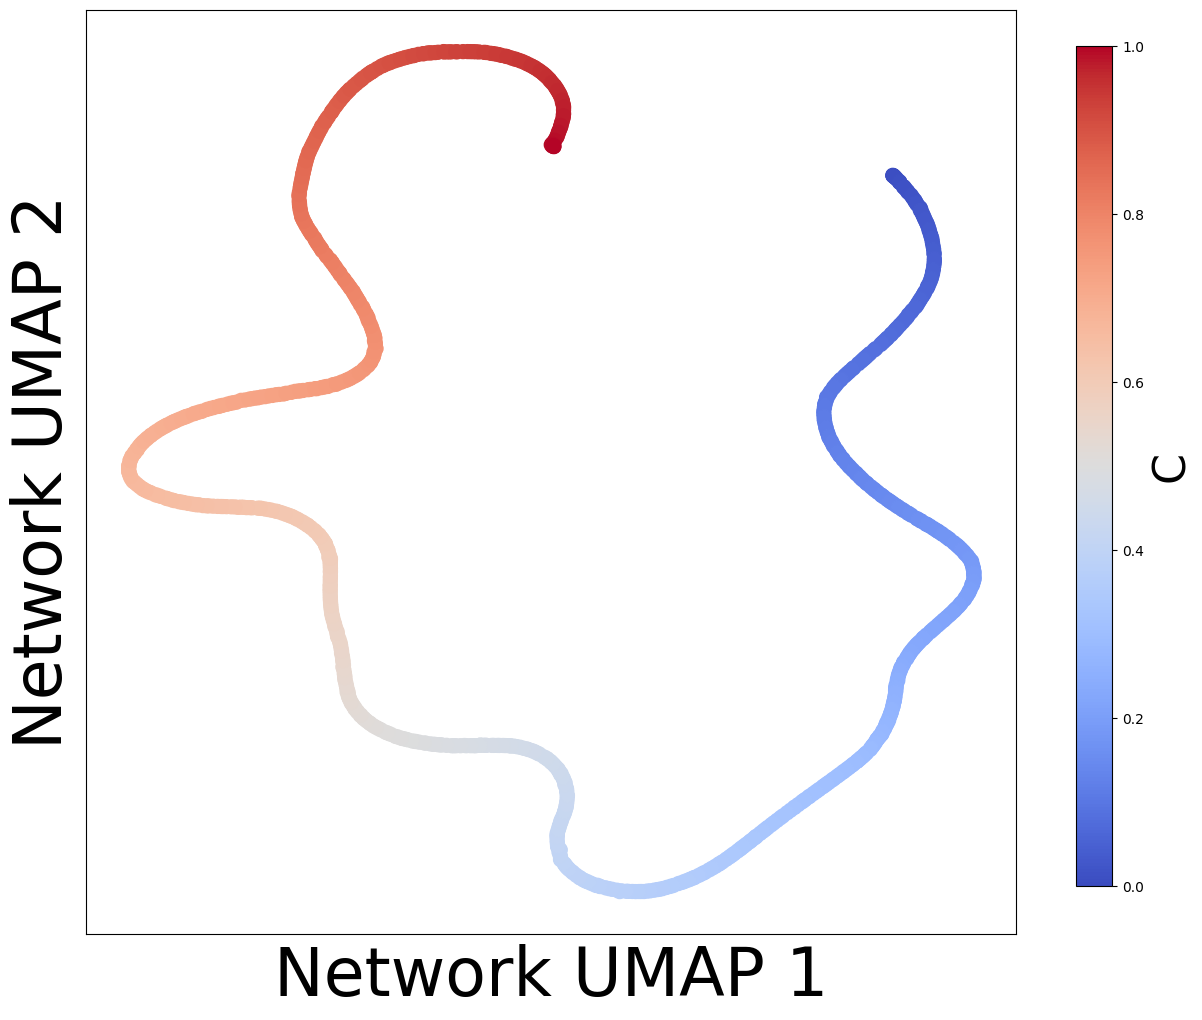

In [6]:
# We can embed networks in lower-dimensional spaces to visualize distributions.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
import umap
import pandas as pd
low_dim_networks = umap.UMAP().fit_transform(predicted_networks.reshape((n, -1)))
plot_embedding_for_all_covars(low_dim_networks[:, :2], pd.DataFrame(C, columns=['C']),
                             xlabel="Network UMAP 1", ylabel="Network UMAP 2")
# In this case, there is only 1 context variable so the embeddings are not very interesting.

# DAG Loss Regularizers
Contextualized Bayesian Networks are available with two types of DAG losses:

- [NOTEARS](https://arxiv.org/abs/1803.01422)
- [DAGMA](https://arxiv.org/pdf/2209.08037)
    
These can be chosen for the archetypes and the sample-specific graphs independently by using the `dag.loss_type` parameter:

`archetype_dag_loss_type="NOTMAD"` or `archetype_dag_loss_type="DAGMA"`

and similarly

`sample_specific_dag_loss_type="NOTMAD"` or `sample_specific_dag_loss_type="DAGMA"`.

NOTEARS has parameters:
- `alpha` (float)
- `rho` (float)
- `use_dynamic_alpha_rho` (Boolean)


DAGMA has parameters:
- `alpha` (strength, default 1e0)
- `s` (max spectral radius, default 1)

# Factor Graphs
To improve scalability, we can include factor graphs (low-dimensional axes of network variation).
This is controlled by the `num_factors` parameter. The default value of 0 turns off factor graphs and computes the network in full dimensionality.